In [19]:
"""This file performs the training of the segmentation."""
import nbimporter
from data_preparation import unzip_training_testing
from sklearn.model_selection import KFold
import os
import gzip
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
import monai
from PIL import Image
import torch
import nibabel as nib
import scipy.ndimage as ndi
from monai.transforms import Compose
import random
from tqdm import tqdm
import wandb
from monai.transforms import (
    EnsureChannelFirstd,
    ScaleIntensityRangePercentilesd,
    RandZoomd, ToTensord,
    SpatialPadd, RandSpatialCropd,
    RandRotated
    )

In [20]:
# Set a random seed for everything
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Function to set the seed for each worker
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


monai.utils.set_determinism(seed=42)

In [21]:
data_path = r'/home/jovyan/Medical images/heart/database/'

In [22]:
def build_dict_hearts(data_path, mode='training', phase=None):
    """
    This function returns a list of dictionaries, each dictionary containing
    the keys 'img_sys' and 'mask_sys', and 'img_dia' and 'mask_dia' that
    returns the path to the corresponding image.

    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'training' or 'testing'.
        phase (str): specify phase for the testing data. Must correspond
        'sys' or 'dia'.

    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths
        of X-ray images and masks.
    """
    # test if mode is correct
    if mode not in ["training", "testing"]:
        raise ValueError(f"Please choose a mode in ['training', 'testing'].\
        Current mode is {mode}.")
    if mode == 'testing':
        if phase is None:
            raise ValueError(f"Choose a phase for the testing mode.\
            Current phase is {phase}.")

    dicts = []
    chosen_path = os.path.join(data_path, mode)
    patient_list = os.listdir(chosen_path)
    patient_list.remove('MANDATORY_CITATION.md')

    for patient_nr in patient_list:
        current_patient = os.path.join(chosen_path, patient_nr)

        # Read systolic and diastolic frames from the info file
        info_path = os.path.join(current_patient, 'Info.cfg')
        info_file = open(info_path, "r")
        ed_phase = info_file.readline().split()[1]
        if len(ed_phase) == 1:
            ed_phase = '0' + ed_phase
        es_phase = info_file.readline().split()[1]
        if len(es_phase) == 1:
            es_phase = '0' + es_phase

        # Create the file names
        img_sys_file = patient_nr + '_frame' + es_phase + '.nii'
        mask_sys_file = patient_nr + '_frame' + es_phase + '_gt.nii'
        img_dia_file = patient_nr + '_frame' + ed_phase + '.nii'
        mask_dia_file = patient_nr + '_frame' + ed_phase + '_gt.nii'

        # Create the file paths
        img_sys = os.path.join(mode, patient_nr, img_sys_file)
        mask_sys = os.path.join(mode, patient_nr, mask_sys_file)
        img_dia = os.path.join(mode, patient_nr, img_dia_file)
        mask_dia = os.path.join(mode, patient_nr, mask_dia_file)

        # Save both phases for training or separate phases for testing
        if mode == 'training':
            dicts.append({'img': img_sys, 'mask': mask_sys})
            dicts.append({'img': img_dia, 'mask': mask_dia})
        elif mode == 'testing':
            if phase == 'sys':
                dicts.append({'img': img_sys, 'mask': mask_sys})
            elif phase == 'dia':
                dicts.append({'img': img_dia, 'mask': mask_dia})

    return dicts


class LoadHeartData(monai.transforms.Transform):
    """
    This function returns a dictionary of the data in the dictionary.
    The original size of the image is also saved.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = nib.load(data_path + sample['img']).get_fdata()
        mask = nib.load(data_path + sample['mask']).get_fdata()
        return {'img': image, 'mask': mask, 'original_size': image.shape}

In [23]:
train_transform = Compose([LoadHeartData(),
                           EnsureChannelFirstd(keys=['img', 'mask'], channel_dim='no_channel'),
                           ScaleIntensityRangePercentilesd(keys=['img'], lower=5, upper=95, b_min=1, b_max=10),
                           SpatialPadd(keys=['img', 'mask'], spatial_size=[256, 256, 16],method='end'),
                           RandZoomd(keys=['img', 'mask'], prob=1, min_zoom=0.7, max_zoom=2, mode=['area', 'nearest']),
                           RandSpatialCropd(keys=['img', 'mask'], roi_size=[256, 256, 16], random_size=False),
                           ToTensord(keys=['img', 'mask'])
                           ])
val_transform = Compose([LoadHeartData(),
                         EnsureChannelFirstd(keys=['img', 'mask'], channel_dim='no_channel'),
                         ScaleIntensityRangePercentilesd(keys=['img'], lower=5, upper=95, b_min=1, b_max=10),
                         SpatialPadd(keys=['img', 'mask'], spatial_size=[256, 256, 16], method='end'),
                         RandSpatialCropd(keys=['img', 'mask'], roi_size=[256, 256, 16], random_size=False),
                         ToTensord(keys=['img', 'mask'])
                         ])
test_transform = Compose([LoadHeartData(),
                         EnsureChannelFirstd(keys=['img', 'mask'], channel_dim='no_channel'),
                         ScaleIntensityRangePercentilesd(keys=['img'], lower=5, upper=95, b_min=1, b_max=10),
                         SpatialPadd(keys=['img', 'mask'], spatial_size=[256, 256, 16], method='end'),
                         ToTensord(keys=['img', 'mask'])
                         ])

In [9]:
heart_list = build_dict_hearts(data_path)
print(len(heart_list))
# construct CacheDataset from list of paths + transform
train_dataset = monai.data.CacheDataset(heart_list, transform=train_transform)

200


Loading dataset: 100%|██████████| 200/200 [00:13<00:00, 14.44it/s]


In [10]:
train_dataloader = monai.data.DataLoader(train_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker)

In [11]:
dataloader_vis_test = monai.data.DataLoader(train_dataset, batch_size=1, shuffle=True, worker_init_fn=seed_worker)

In [8]:
def visualize_rib_sample(sample, slice=0, title=None):
    """
    Create a figure showing the transformed image and its mask.
    """
    image = np.squeeze(sample['img'])
    mask = np.squeeze(sample['mask'])
    image = image[:,:,slice]
    mask = mask[:,:,slice]
    cmap = mcolors.ListedColormap(['none', 'red', 'green', 'blue'])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    plt.figure(figsize=[10, 7])
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap=cmap, norm=norm, alpha=0.5, interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.show()

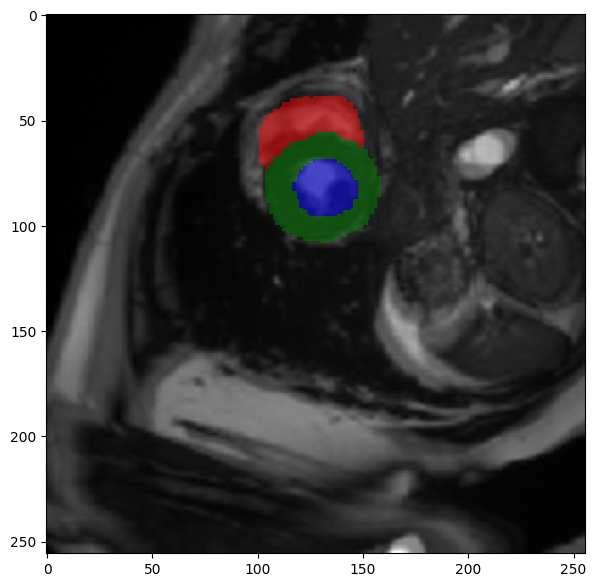

In [9]:
data_iter = iter(dataloader_vis_test)
first_batch = next(data_iter)
visualize_rib_sample(first_batch)

In [122]:
distribution_transform = Compose([LoadHeartData(),
                           EnsureChannelFirstd(keys=['img', 'mask'], channel_dim='no_channel'),
                           ToTensord(keys=['img', 'mask'])
                           ])

In [123]:
distribution_list = build_dict_hearts(data_path)
print(len(distribution_list))
# construct CacheDataset from list of paths + transform
distribution_dataset = monai.data.CacheDataset(distribution_list, transform=distribution_transform)

200


Loading dataset: 100%|██████████| 200/200 [00:03<00:00, 64.58it/s]


In [124]:
distribution_loader = monai.data.DataLoader(distribution_dataset, batch_size=1, shuffle=True, worker_init_fn=seed_worker)

In [135]:
# Investigate class distribution of one patient
first_batch = next(iter(distribution_loader))
sample_mask = np.squeeze(first_batch['mask'])
print(sample_mask.shape)
slices = sample_mask.shape[2]
print(slices)
intensities = []
for slice_index in range(slices):
    slice_sample = sample_mask[:, :, slice_index]
    slice_intensities = slice_sample.flatten()
    intensities.extend(slice_intensities)
    print(slice_index)

unique_values = set(intensities)
print(unique_values)
zeros = intensities.count(0)
ones = intensities.count(1)
twos = intensities.count(2)
threes = intensities.count(3)
total_elements = zeros + ones + twos + threes

if len(intensities) == total_elements:
    print('yes, seems good')
else:
    print('No, the numbers did not match')

quantity = [zeros, ones, twos, threes]
classes = ['Background', 'Right ventricle', 'Myocardium', 'Left ventricle']

(208, 256, 10)
10
0
1
2
3
4
5
6
7
8
9
{0.0, 1.0, 2.0, 3.0}
yes, seems good


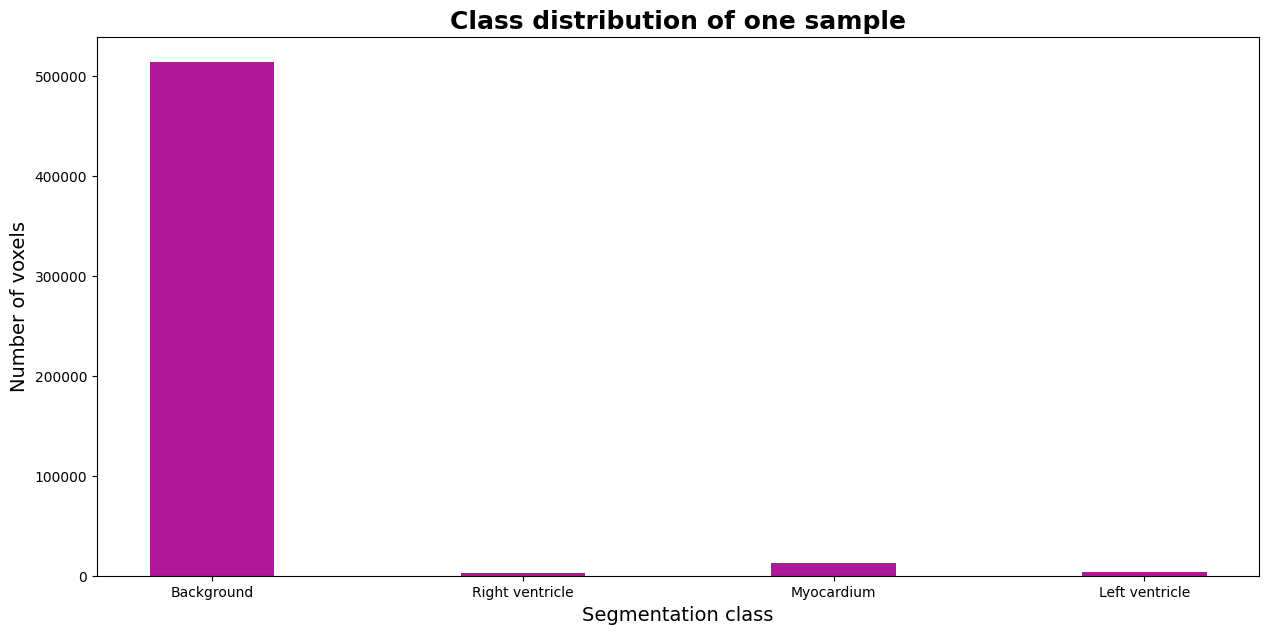

In [136]:
# Create a bar plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
color = '#B0189C'
plt.bar(classes, quantity, color=color, width=0.4)

plt.xlabel("Segmentation class", fontsize=14)
plt.ylabel("Number of voxels", fontsize=14)
plt.title("Class distribution of one sample", fontweight='bold', fontsize=18)

#plt.xticks(pixel_value, [str(val) for val in pixel_value])

plt.savefig('bar_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [24]:
heart_list_test_sys = build_dict_hearts(data_path, mode='testing', phase='sys')
print(len(heart_list_test_sys))
# construct CacheDataset from list of paths + transform
test_dataset_sys = monai.data.CacheDataset(heart_list_test_sys, transform=val_transform)

50


Loading dataset: 100%|██████████| 50/50 [00:04<00:00, 12.22it/s]


In [13]:
heart_list_test_dia = build_dict_hearts(data_path, mode='testing', phase='dia')
print(len(heart_list_test_dia))
# construct CacheDataset from list of paths + transform
test_dataset_dia = monai.data.CacheDataset(heart_list_test_dia, transform=val_transform)

50


Loading dataset: 100%|██████████| 50/50 [00:03<00:00, 14.80it/s]


In [14]:
val_dataloader_sys = monai.data.DataLoader(test_dataset_sys, batch_size=16, shuffle=True, worker_init_fn=seed_worker)
val_dataloader_dia = monai.data.DataLoader(test_dataset_dia, batch_size=16, shuffle=True, worker_init_fn=seed_worker)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda


In [26]:
if torch.cuda.is_available():
    dev = "cuda:1"
else:
    dev = "cpu"
device = torch.device(dev)
print(f'The used device is {device}')

The used device is cuda:1


In [17]:
class_weights = [0.2, 1, 1, 1]
loss_function =  monai.losses.DiceLoss(softmax=True, batch=True, weight = class_weights)

model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,
    channels=(8, 16, 32, 64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2, 1, 1, 1),
    num_res_units=5,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# Train with cross-validation

from tqdm import tqdm

def train_loop(model, train_dataset, optimizer, epochs, device=device):
    default_model = model
    kf = KFold(n_splits=5)
    scores = []
    eval_metrics = []

    for train_index, val_index in kf.split(range(len(train_dataset))):
        train_subset = torch.utils.data.Subset(train_dataset, train_index)
        val_subset = torch.utils.data.Subset(train_dataset, val_index)

        train_loader = monai.data.DataLoader(train_subset, batch_size=10, shuffle=True)
        val_loader = monai.data.DataLoader(val_subset, batch_size=10, shuffle=False)

        model = default_model
        for epoch in tqdm(range(epochs)):
            model.train()

            for batch in train_loader:
                optimizer.zero_grad()
                images = batch['img'].float().to(device)
                labels = batch['mask'].float().to(device)
                labels = torch.nn.functional.one_hot(labels.long(), num_classes=4)
                labels = torch.transpose(labels, -1, 1).squeeze(-1)
                output = model(images)
                loss = loss_function(output, labels)
                loss.backward()
                optimizer.step()

        with torch.no_grad():
            # validation loop
            model.eval()
            val_loss = 0
            mean_value = 0
            for batch in val_loader:
                images = batch['img'].float().to(device)
                labels = batch['mask'].float().to(device)
                labels = torch.nn.functional.one_hot(labels.long(), num_classes=4)
                labels = torch.transpose(labels, -1, 1).squeeze(-1)
                output = model(images)
                loss = loss_function(output, labels).item()
                val_loss += loss

                softmax = torch.nn.Softmax(dim=1)
                mask_outputs = output.float()
                mask_outputs = softmax(mask_outputs)
                argmax_indices = torch.argmax(mask_outputs, dim=1)
                reconstructed_images = argmax_indices.long()
                reconstructed_images = torch.nn.functional.one_hot(reconstructed_images, num_classes=4)
                reconstructed_images = reconstructed_images.permute(0, 4, 1, 2, 3) 
                metric_fn = monai.metrics.DiceMetric(include_background=True, reduction="mean")
                dice_score = metric_fn(reconstructed_images, labels).cpu().numpy()
                mean_value += dice_score

            len_val = 40
            mean_value = np.sum(mean_value, axis=0)
            print(mean_value)
            mean_value = mean_value / len_val
            avg_val_loss = val_loss / len_val
            scores.append(avg_val_loss)
            eval_metrics.append(mean_value)

    return scores, eval_metrics

n_epochs = 20
scores, eval_metrics = train_loop(model, train_dataset, optimizer, epochs=n_epochs)
print(scores)

100%|██████████| 20/20 [15:27<00:00, 46.35s/it]


[39.72908  25.64293  23.831211 32.401752]


100%|██████████| 20/20 [15:29<00:00, 46.46s/it]


[39.77222  29.20141  26.51284  34.048744]


100%|██████████| 20/20 [15:15<00:00, 45.79s/it]


[39.864937 30.939178 30.072216 35.998356]


100%|██████████| 20/20 [15:23<00:00, 46.17s/it]


[39.84869  27.959883 29.357191 35.722954]


100%|██████████| 20/20 [15:27<00:00, 46.38s/it]


[39.87841  29.457373 32.27314  33.711674]
[0.02241714932024479, 0.01669556424021721, 0.012895901314914226, 0.015255575999617577, 0.01216520443558693]


In [11]:
values = []
for i in range(4):
    for arr in eval_metrics:
        values.append(arr[i])
        
# Given values
#values_4 = [0.65525633, 0.69911605, 0.7790867, 0.65918636, 0.7298845]

        # Calculate mean and standard deviation
    mean_4 = np.mean(values)
    std_dev_4 = np.std(values)

    print(f'Mean {i}:', mean_4)
    print(f'Standard Deviation {i}:', std_dev_4)
    values = []

Mean 0: 0.9954667
Standard Deviation 0: 0.00144891
Mean 1: 0.7160039
Standard Deviation 1: 0.044320557
Mean 2: 0.7102329
Standard Deviation 2: 0.073440894
Mean 3: 0.85941744
Standard Deviation 3: 0.03333992


In [14]:
# Use a scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: frida-lofgren (medical_images_frida). Use `wandb login --relogin` to force relogin


True

In [18]:
run = wandb.init(
    project='ACDC_segmentation',
    name='test_20',
    config={
        'loss function': str(loss_function),
        'lr': optimizer.param_groups[0]["lr"],
        'batch_size': train_dataloader.batch_size,
    }
)

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def wandb_masks(mask_output, mask_gt, epoch):
    """ Function that generates a mask dictionary in format that W&B requires """
    # Apply softmax to output channels
    softmax = torch.nn.Softmax(dim=0)
    mask_output = mask_output.float()
    mask_output = softmax(mask_output)

    # Convert the channels to one image
    argmax_indices = torch.argmax(mask_output, dim=0)
    reconstructed_image = argmax_indices.long()

    # Choose a slice
    reconstructed_image = reconstructed_image[:, :, 8]
    mask_gt = mask_gt[:, :, :, 8]
    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = reconstructed_image.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()


    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'Right ventricle',
                    2: 'Myocardium',
                    3: 'Left ventricle'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks


def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [wandb.Image(img[:, :, :, 8], masks=wandb_masks(mask_output, mask_gt, epoch)) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})


def train_loop(model, train_dataloader, val_dataloader_sys, val_dataloader_dia, optimizer, epochs, device=device, val_freq=1):
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        val_loss = 0
        model.train()
        steps = 0
        epoch_loss = 0

        for batch in train_dataloader:
            optimizer.zero_grad()
            images = batch['img'].float().to(device)
            labels = batch['mask'].float().to(device)
            labels = torch.nn.functional.one_hot(labels.long(), num_classes=4)
            labels = torch.transpose(labels, -1, 1).squeeze(-1)
            output = model(images)
            loss = loss_function(output, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            steps += 1

        train_loss = epoch_loss/steps

        # validation loop
        if epoch % val_freq == 0:
            with torch.no_grad():
                steps = 0
                val_epoch_loss = 0
                model.eval()
                for batch in val_dataloader_sys:
                    images = batch['img'].float().to(device)
                    labels = batch['mask'].float().to(device)
                    labels = torch.nn.functional.one_hot(labels.long(), num_classes=4)
                    labels = torch.transpose(labels, -1, 1).squeeze(-1)
                    output = model(images)
                    loss = loss_function(output, labels).item()
                    val_epoch_loss += loss
                    steps += 1
                for batch in val_dataloader_dia:
                    images = batch['img'].float().to(device)
                    labels = batch['mask'].float().to(device)
                    labels = torch.nn.functional.one_hot(labels.long(), num_classes=4)
                    labels = torch.transpose(labels, -1, 1).squeeze(-1)
                    output = model(images)
                    loss = loss_function(output, labels).item()
                    val_epoch_loss += loss
                    steps += 1
                val_loss = val_epoch_loss/steps

        log_to_wandb(epoch, train_loss, val_loss, batch, output)


val_freq = 1
n_epochs = 75
train_loop(model, train_dataloader, val_dataloader_sys, val_dataloader_dia, optimizer, epochs=n_epochs, val_freq=val_freq)

# Store the network parameters
torch.save(model.state_dict(), r'trainedUNet_20.pt')
run.finish()

100%|██████████| 75/75 [1:22:58<00:00, 66.39s/it]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,██▇▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▄▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,74
train_loss,0.11271
val_loss,0.20038


In [29]:
test_dict_sys = build_dict_hearts(data_path, mode='testing', phase='sys')
test_dict_dia = build_dict_hearts(data_path, mode='testing', phase='dia')
test_set_sys = monai.data.CacheDataset(test_dict_sys, transform=test_transform)
test_set_dia = monai.data.CacheDataset(test_dict_dia, transform=test_transform)
test_loader_sys = monai.data.DataLoader(test_set_sys, batch_size=1, shuffle=False, worker_init_fn=seed_worker)
test_loader_dia = monai.data.DataLoader(test_set_dia, batch_size=1, shuffle=False, worker_init_fn=seed_worker)

Loading dataset: 100%|██████████| 50/50 [00:04<00:00, 10.78it/s]


In [37]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,
    channels=(8, 16, 32, 64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2, 1, 1, 1),
    num_res_units=5,
).to(device)

In [38]:
# Load the state dictionary
state_dict = torch.load(r'/home/jovyan/Medical images/trainedUNet_20.pt')
# Load state dict into model
model.load_state_dict(state_dict)

<All keys matched successfully>

In [51]:
from monai.inferers import SlidingWindowInferer

def compute_metric(dataloader, model, metric_fn, phase):
    """
    This function computes the average value of a metric for a data set.
    
    Args:
        dataloader (monai.data.DataLoader): dataloader with batch size 1.
        model (torch.nn.Module): trained model to evaluate.
        metric_fn (function): function computing the metric value from two tensors:
            - a batch of outputs,
            - the corresponding batch of ground truth masks.
        
    Returns:
        a list with mean value for each class
    """
    model.eval()
    
    mean_value = 0
    sample_counter = 0
    if phase == 'sys':
        output_folder = r'/home/jovyan/Medical images/segmented_sys'
    elif phase == 'dia':
        output_folder = r'/home/jovyan/Medical images/segmented_dia'

    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256, 256, 16])

    for sample in dataloader:
        with torch.no_grad():
            images = sample['img'].float().to(device)
            labels_gt = sample['mask'].float().to(device)
            original_size = sample['original_size']
            print(labels_gt.shape)
            labels_gt = labels_gt[:,:,0:original_size[0],0:original_size[1], 0:original_size[2]].float()
            labels = torch.nn.functional.one_hot(labels_gt.long(), num_classes=4)
            labels = torch.transpose(labels, -1, 1).squeeze(-1)
            output = inferer(images, network=model)
            cropped_output = output[:,:,0:original_size[0],0:original_size[1], 0:original_size[2]].float()

            # Postprocess output
            softmax = torch.nn.Softmax(dim=1)
            mask_output = cropped_output.float()
            mask_output = softmax(mask_output)
            argmax_indices = torch.argmax(mask_output, dim=1)
            reconstructed_image = argmax_indices.long()
            
            one_hot_image = torch.nn.functional.one_hot(reconstructed_image, num_classes=4)
            print(f'Before permute, img: {one_hot_image.shape}')
            one_hot_image = one_hot_image.permute(0, 4, 1, 2, 3)
            print(f'After permute, img: {one_hot_image.shape}')
            print(f'Labels: {labels.shape}')
            
            dice_score = metric_fn(one_hot_image, labels).cpu().numpy()
            mean_value += dice_score

            # Create a NIfTI image object
            affine = np.eye(4)
            save_images = reconstructed_image[0,:,:,:].cpu().numpy().astype(np.float32)
            save_labels = labels_gt[0,0,:,:,:].cpu().numpy().astype(np.float32)
            convert_img = nib.Nifti1Image(save_images, affine)
            convert_label = nib.Nifti1Image(save_labels, affine)

            # Save the image to a file
            output_filename = f'patient_{sample_counter}.nii'
            labels_filename = f'patient_{sample_counter}_gt.nii'
            sample_counter += 1
            output_file_path = os.path.join(output_folder, output_filename)
            labels_file_path = os.path.join(output_folder, labels_filename)
            nib.save(convert_img, output_file_path)
            nib.save(convert_label, labels_file_path)
            print(f'Saved image to {output_file_path}')
            print(f'Saved image to {labels_file_path}')

    len_val = len(dataloader)
    print(mean_value)
    mean_value = mean_value / len_val
    return mean_value

In [52]:
compute_metric(test_loader_sys, model, monai.metrics.DiceMetric(include_background=True, reduction="mean"), phase='sys')

torch.Size([1, 1, 256, 256, 16])
Before permute, img: torch.Size([1, 216, 256, 9, 4])
After permute, img: torch.Size([1, 4, 216, 256, 9])
Labels: torch.Size([1, 4, 216, 256, 9])
Saved image to /home/jovyan/Medical images/segmented_sys/patient_0.nii
Saved image to /home/jovyan/Medical images/segmented_sys/patient_0_gt.nii
torch.Size([1, 1, 256, 256, 16])
Before permute, img: torch.Size([1, 224, 180, 8, 4])
After permute, img: torch.Size([1, 4, 224, 180, 8])
Labels: torch.Size([1, 4, 224, 180, 8])
Saved image to /home/jovyan/Medical images/segmented_sys/patient_1.nii
Saved image to /home/jovyan/Medical images/segmented_sys/patient_1_gt.nii
torch.Size([1, 1, 256, 256, 16])
Before permute, img: torch.Size([1, 240, 256, 10, 4])
After permute, img: torch.Size([1, 4, 240, 256, 10])
Labels: torch.Size([1, 4, 240, 256, 10])
Saved image to /home/jovyan/Medical images/segmented_sys/patient_2.nii
Saved image to /home/jovyan/Medical images/segmented_sys/patient_2_gt.nii
torch.Size([1, 1, 256, 256, 

array([[0.9935746 , 0.6504135 , 0.6985626 , 0.75339293]], dtype=float32)

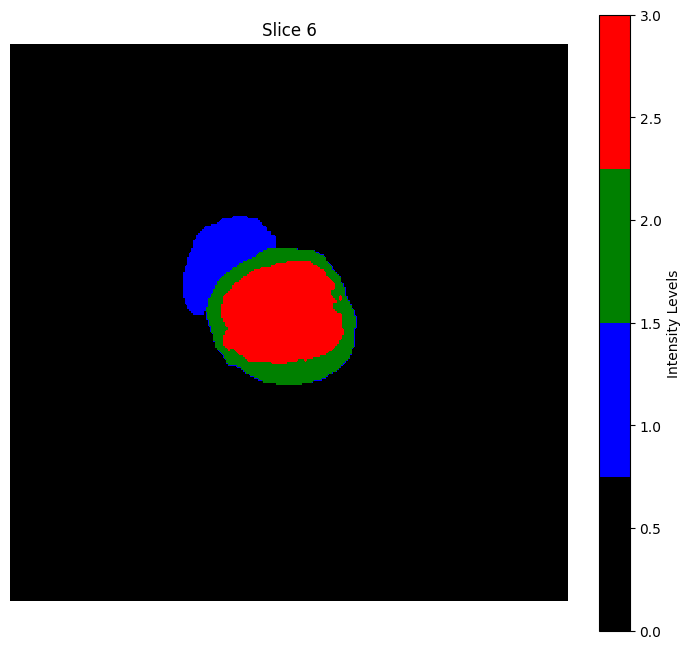

In [17]:
# Load NIfTI file
img = nib.load('/home/jovyan/Medical images/segmented/patient_18.nii')

# Get NIfTI data array
img_data = img.get_fdata()

# Select slice number 6 (adjust as needed)
slice_number = 6
slice_data = img_data[:, :, slice_number]

# Define a custom colormap with 4 colors (adjust colors as needed)
colors = ['black', 'blue', 'green', 'red']
cmap = plt.cm.colors.ListedColormap(colors)

# Display the selected slice using Matplotlib
fig, ax = plt.subplots(figsize=(8, 8))  # adjust figsize as needed
img_plot = ax.imshow(slice_data, cmap=cmap, vmin=0, vmax=3)  # adjust vmin and vmax according to your intensity range
ax.set_title(f"Slice {slice_number}")
ax.axis('off')

# Create a colorbar for the custom colormap
norm = plt.cm.colors.Normalize(vmin=0, vmax=3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05)
cbar.set_label('Intensity Levels')

plt.show()


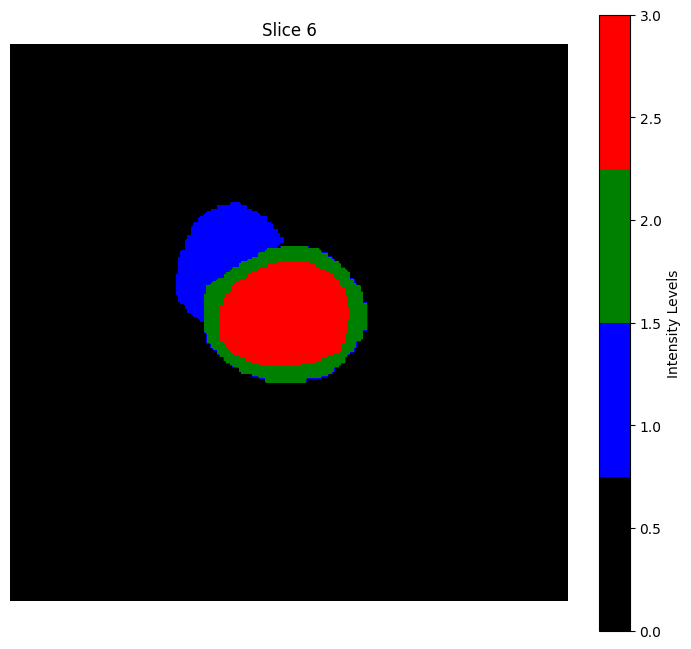

In [18]:
# Load NIfTI file
img = nib.load('/home/jovyan/Medical images/segmented/patient_18_gt.nii')

# Get NIfTI data array
img_data = img.get_fdata()

# Select slice number 6 (adjust as needed)
slice_number = 6
slice_data = img_data[:, :, slice_number]

# Define a custom colormap with 4 colors (adjust colors as needed)
colors = ['black', 'blue', 'green', 'red']
cmap = plt.cm.colors.ListedColormap(colors)

# Display the selected slice using Matplotlib
fig, ax = plt.subplots(figsize=(8, 8))  # adjust figsize as needed
img_plot = ax.imshow(slice_data, cmap=cmap, vmin=0, vmax=3)  # adjust vmin and vmax according to your intensity range
ax.set_title(f"Slice {slice_number}")
ax.axis('off')

# Create a colorbar for the custom colormap
norm = plt.cm.colors.Normalize(vmin=0, vmax=3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05)
cbar.set_label('Intensity Levels')

plt.show()